# Notebook Containing the data generation, NN Modelling and Optimization Attempts for two windturbines

In [1]:
### Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

from pyomo import environ
from pyomo.core import *
import pyomo.environ as pyo
import gurobipy
import itertools


import torch


import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), 'DistCL_code_modified'))
from distcl import distcl

## Load Data

In [2]:
# Load Data
data = pd.read_csv("data/two_turbine_simulation_data_var_wind_dir.csv")
data.head()

,x_turb2,y_turb2,wind_speed,wind_direction,turbulence_intensity,turbine1_power,turbine2_powers,farm_power
0,0.0,0.0,8.0,0.0,0.06,1753.954459,1753.954459,3507.908918
1,0.0,0.0,8.0,10.0,0.06,1753.954459,1753.954459,3507.908918
2,0.0,0.0,8.0,20.0,0.06,1753.954459,1753.954459,3507.908918
3,0.0,0.0,8.0,30.0,0.06,1753.954459,1753.954459,3507.908918
4,0.0,0.0,8.0,40.0,0.06,1753.954459,1753.954459,3507.908918


In [3]:
def expected_power_for_location(x_turb2_value, y_turb2_value, wind_df, cl_tool):
    # Use the wind_direction and probability from wind_df
    wind_directions = wind_df['wind_direction'].values
    probabilities = wind_df['probability'].values

    # Set constant wind_speed and turbulence_intensity
    wind_speed_value = 8
    turbulence_intensity_value = 0.06

    # Create the DataFrame
    data_pred = pd.DataFrame({
        'x_turb2': x_turb2_value,
        'y_turb2': y_turb2_value,
        'wind_speed': wind_speed_value,
        'wind_direction': wind_directions,
        'turbulence_intensity': turbulence_intensity_value,
        'probability': probabilities
    })

    generated_data = pd.DataFrame(data_pred, columns=["x_turb2", "y_turb2", "wind_speed", "wind_direction", "turbulence_intensity"])
    data_pred["pred_power"] = cl_tool.predict(X=generated_data[["x_turb2", "y_turb2", "wind_speed", "wind_direction", "turbulence_intensity"]])
    expected_power = (data_pred["pred_power"] * data_pred["probability"]).sum()
    return expected_power

# Train NN and generate constraints

In [4]:
# Test/Train Split
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

val_ind = val_data.index
test_ind = test_data.index

In [34]:
# Retrain the model with the best parameters
cl_tool = distcl(X=data[["x_turb2", "y_turb2", "wind_speed", "wind_direction", "turbulence_intensity"]],#, "turbulence_intensity"]],
            y=data["farm_power"], n_preds=1, val_ind=val_ind, test_ind=test_ind)

model_nn, preds_test, y_test = cl_tool.train(n_hidden=3, n_nodes=8, iters=2, drop=0.05, learning_rate=1e-3)
#torch.save(model_nn, "models/prob_2neuron2layers.pth")

#model_nn = cl_tool.load_model(path="models/prob_extended.pth")
#model_nn = cl_tool.load_model(path="models/prob_1neuron.pth")

DistFCNN(
  (lin_layers): ModuleList(
    (0): Linear(in_features=5, out_features=8, bias=True)
    (1-2): 2 x Linear(in_features=8, out_features=8, bias=True)
  )
  (output_mean_layer): Linear(in_features=8, out_features=1, bias=True)
  (droput_layers): ModuleList(
    (0-2): 3 x Dropout(p=0.05, inplace=False)
  )
)
cpu
epoch 0 loss 1.0108633041381836
NN fitting process finished with a validation MSE loss of 0.9607388377189636 in epoch 1


In [35]:
cons = cl_tool.constraint_build(model_nn)
cons.to_csv('inputs/constraints_twoturbines.csv')
cons = pd.read_csv('inputs/constraints_twoturbines.csv', index_col=0)
cons

,intercept,layer,node,node_0,node_1,node_2,node_3,node_4,node_5,node_6,node_7
0,0.088086,0,0,-0.003348,0.076828,-0.368077,-0.542153,-0.159396,NaN,NaN,NaN
1,-0.240247,0,1,0.119924,-0.002505,0.354591,-0.028803,0.107370,NaN,NaN,NaN
2,0.094530,0,2,-0.135154,-0.202582,-0.427245,-0.495310,-0.128288,NaN,NaN,NaN
3,-0.359090,0,3,0.016566,0.021686,0.268338,-0.506142,-0.223911,NaN,NaN,NaN
4,-0.104503,0,4,0.162436,0.601477,-0.092037,0.363836,-0.105875,NaN,NaN,NaN
5,-0.192781,0,5,0.047322,0.274811,-0.414867,-0.367141,-0.215504,NaN,NaN,NaN
6,0.237027,0,6,-0.174324,0.500976,-0.289875,-0.029772,-0.220825,NaN,NaN,NaN
7,0.513291,0,7,-0.418843,-0.226287,0.384424,0.286305,-0.008864,NaN,NaN,NaN
0,-0.261212,1,0,-0.214931,-0.012757,0.179496,0.308076,0.044931,0.010132,0.185574,-0.228781
1,0.408237,1,1,0.052496,-0.266001,-0.252155,-0.240659,0.397123,0.141488,-0.102740,0.268326


# Wind distribution

In [ ]:
# Generate distribution of wind directions
from scipy.stats import norm

# Parameters
mu = 280
sd = 30
angles = np.arange(0, 360, 10)

# Circular distance function
def circular_dist(x, mu):
    d = np.abs(x - mu) % 360
    return np.minimum(d, 360 - d)

# Apply normal PDF to circular distances
distances = circular_dist(angles, mu)
densities = norm.pdf(distances, loc=0, scale=sd)
probabilities = densities / np.sum(densities)

# Create DataFrame
wind_df = pd.DataFrame({
    'wind_direction': angles,
    'probability': np.round(probabilities, 5)
})

# add variables for correct format
wind_df = wind_df[wind_df['probability'] > 0].reset_index(drop=True)
wind_df.insert(0, 'x_turb2', np.nan)
wind_df.insert(1, 'y_turb2', np.nan)
wind_df['wind_speed'] = 8
wind_df['turbulence_intensity'] = 0.06

# Plot
plt.figure(figsize=(10, 5))
plt.bar(wind_df['wind_direction'], wind_df['probability'], width=8, align='center', color='skyblue', edgecolor='black')
plt.title('Discrete Wrapped Normal Distribution of Wind Direction\n(mean=270°, sd=20°)')
plt.xlabel('Wind Direction (Degrees)')
plt.ylabel('Probability')
plt.xticks(np.arange(0, 361, 30))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



# Optimization Model



### Decision Variables
\( x \): x-coordinate of the second turbine relative to the first.
\( y \): y-coordinate of the second turbine relative to the first.

### **Objective Function**
$$ \max_{x, y} P(x, y) $$

### Constraints
$ x_{\min} \leq x \leq x_{\max} $
   
$ y_{\min} \leq y \leq y_{\max} $


In [51]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, minimize, value

### Define the optimization model
model = ConcreteModel()

# set up scenarios with probabilities and contextual information
contextual_sample = wind_df.drop(columns=['probability'])
pi = list(wind_df['probability'])

n_sc = len(contextual_sample)
model.W = pyo.RangeSet(0,n_sc-1)

# set up 
model.var_ind = pyo.Set(initialize=contextual_sample.columns.sort_values())

model.x = pyo.Var(model.var_ind, model.W ,within=pyo.Reals)
model.y = pyo.Var(pyo.Any, dense=False, domain=pyo.Reals) # learned variables (demand)

model.power = pyo.Var(model.W,within=pyo.Reals) # saving power per scenario


# obj function 
def obj_expression(model):
    return sum(pi[w-1] * model.power[w] for w in model.W)
model.OBJ = pyo.Objective(rule=obj_expression, sense=pyo.maximize)

#power generation
def power(model, w):
    return model.power[w] == model.y['power', 0, w]
model.const_power = pyo.Constraint(model.W, rule=power)


# Fix contextual variables
def fix_other_vars(model, x_ind, w):
    if x_ind not in ['x_turb2', 'y_turb2']:
        return model.x[x_ind, w] == contextual_sample.loc[w, x_ind]
    return pyo.Constraint.Skip
model.const_fix_other_vars = pyo.Constraint(model.var_ind, model.W, rule=fix_other_vars)

# Constraint to ensure x_turb2 and y_turb2 are the same across all scenarios
def same_across_scenarios(model, var_name):
    first_scenario = next(iter(model.W))
    return (model.x[var_name, first_scenario] == model.x[var_name, w] for w in model.W if w != first_scenario)

model.const_same_x_turb2 = pyo.ConstraintList()
for constraint in same_across_scenarios(model, 'x_turb2'):
    model.const_same_x_turb2.add(constraint)

model.const_same_y_turb2 = pyo.ConstraintList()
for constraint in same_across_scenarios(model, 'y_turb2'):
    model.const_same_y_turb2.add(constraint)


# Upper bounds for x_turb2 and y_turb2
def x_turb2_ub_rule(model, w):
    return model.x['x_turb2', w] <= 5000
model.x_turb2_ub = pyo.Constraint(model.W, rule=x_turb2_ub_rule)

def y_turb2_ub_rule(model, w):
    return model.x['y_turb2', w] <= 600
model.y_turb2_ub = pyo.Constraint(model.W, rule=y_turb2_ub_rule)

# Lower bounds for x_turb2 and y_turb2
def x_turb2_ub_rule(model, w):
    return model.x['x_turb2', w] >= 0
model.x_turb2_lb = pyo.Constraint(model.W, rule=x_turb2_ub_rule)

def y_turb2_ub_rule(model, w):
    return model.x['y_turb2', w] >= 0
model.y_turb2_lb = pyo.Constraint(model.W, rule=y_turb2_ub_rule)




# lower bounds for x_turb2 and y_turb2
def distance_constraint(model, w):
    return ((model.x['x_turb2', w] - 0)**2 + (model.x['y_turb2', w] - 0)**2) >= 150**2
model.distance_constraint = pyo.Constraint(model.W, rule=distance_constraint)

### Constraint Embedding
cl_tool.const_embed_modified(opt_model=model, constaints=cons, outcome='power', deterministic = True, n_scenarios=n_sc)


Secenario  0 embedded
Layer  0 embedded for prediction  0  of outcome  power
Layer  1 embedded for prediction  0  of outcome  power
Layer  2 embedded for prediction  0  of outcome  power
Layer  3 embedded for prediction  0  of outcome  power
Secenario  1 embedded
Layer  0 embedded for prediction  0  of outcome  power
Layer  1 embedded for prediction  0  of outcome  power
Layer  2 embedded for prediction  0  of outcome  power
Layer  3 embedded for prediction  0  of outcome  power
Secenario  2 embedded
Layer  0 embedded for prediction  0  of outcome  power
Layer  1 embedded for prediction  0  of outcome  power
Layer  2 embedded for prediction  0  of outcome  power
Layer  3 embedded for prediction  0  of outcome  power
Secenario  3 embedded
Layer  0 embedded for prediction  0  of outcome  power
Layer  1 embedded for prediction  0  of outcome  power
Layer  2 embedded for prediction  0  of outcome  power
Layer  3 embedded for prediction  0  of outcome  power
Secenario  4 embedded
Layer  0 e

In [52]:
cons['layer']

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
0    2
1    2
2    2
3    2
4    2
5    2
6    2
7    2
0    3
Name: layer, dtype: int64

In [53]:
model.pprint()

1 Set Declarations
    var_ind : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    5 : {'turbulence_intensity', 'wind_direction', 'wind_speed', 'x_turb2', 'y_turb2'}

1 RangeSet Declarations
    W : Dimen=1, Size=27, Bounds=(0, 26)
        Key  : Finite : Members
        None :   True :  [0:26]

5 Var Declarations
    power : Size=27, Index=W
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :  None :  None :  None : False :  True :  Reals
          1 :  None :  None :  None : False :  True :  Reals
          2 :  None :  None :  None : False :  True :  Reals
          3 :  None :  None :  None : False :  True :  Reals
          4 :  None :  None :  None : False :  True :  Reals
          5 :  None :  None :  None : False :  True :  Reals
          6 :  None :  None :  None : False :  True :  Reals
          7 :  None :  None :  None : False :  True :  Reals
          8 :  None :  None :  None 

In [54]:
# Solve the optimization problem
solver = SolverFactory('gurobi')
solver.options['threads'] = 8
solver.options['NonConvex'] = 2
results = solver.solve(model, tee=True)

Read LP format model from file /var/folders/2j/t8d8dcsn1tg5sc8l4kz4_4ch0000gn/T/tmpyc7uezx4.pyomo.lp
Reading time = 0.03 seconds
x1: 2266 rows, 1512 columns, 12956 nonzeros
Set parameter Threads to value 8
Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 24.5.0 24F74)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 8 threads

Non-default parameters:
NonConvex  2
Threads  8

Optimize a model with 2266 rows, 1512 columns and 12956 nonzeros
Model fingerprint: 0xc937d623
Model has 27 quadratic constraints
Variable types: 864 continuous, 648 integer (648 binary)
Coefficient statistics:
  Matrix range     [2e-05, 1e+03]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e-05, 1e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-02, 5e+03]
  QRHS range       [2e+04, 2e+04]
Presolve removed 518 rows and 341 columns
Presolve time: 0.19s
Presolved: 1788 r

In [55]:
# print optimization results
print("\nOptimization Results:")

# Print the value of the objective function
print("\nObjective Function Value:")
print(pyo.value(model.OBJ))

# Print x variables (contextual features and decision variables)
print("\nContextual/Decision Variables (x):")
for k in model.x:
    print(f"{k}: {pyo.value(model.x[k])}")




Optimization Results:

Objective Function Value:
3505.3161316318206

Contextual/Decision Variables (x):
('turbulence_intensity', 0): 0.06
('turbulence_intensity', 1): 0.06
('turbulence_intensity', 2): 0.06
('turbulence_intensity', 3): 0.06
('turbulence_intensity', 4): 0.06
('turbulence_intensity', 5): 0.06
('turbulence_intensity', 6): 0.06
('turbulence_intensity', 7): 0.06
('turbulence_intensity', 8): 0.06
('turbulence_intensity', 9): 0.06
('turbulence_intensity', 10): 0.06
('turbulence_intensity', 11): 0.06
('turbulence_intensity', 12): 0.06
('turbulence_intensity', 13): 0.06
('turbulence_intensity', 14): 0.06
('turbulence_intensity', 15): 0.06
('turbulence_intensity', 16): 0.06
('turbulence_intensity', 17): 0.06
('turbulence_intensity', 18): 0.06
('turbulence_intensity', 19): 0.06
('turbulence_intensity', 20): 0.06
('turbulence_intensity', 21): 0.06
('turbulence_intensity', 22): 0.06
('turbulence_intensity', 23): 0.06
('turbulence_intensity', 24): 0.06
('turbulence_intensity', 25): 

# Analytics

In [56]:
data_with_prob = pd.merge(data, wind_df[["wind_direction","probability"]], left_on='wind_direction', right_on='wind_direction', how='left')

In [57]:
# Calculate the expected total power generation
data_with_prob['prob_weighted_power'] = data_with_prob['farm_power'] * data_with_prob['probability']

# Group by x_turb2 and y_turb2 to sum the expected power for each combination
expected_power_by_location = data_with_prob.groupby(['x_turb2', 'y_turb2'])['prob_weighted_power'].sum().reset_index()

# Drop rows where x_turb2 and y_turb2 are both 0
expected_power_by_location = expected_power_by_location[(expected_power_by_location['x_turb2'] != 0) | (expected_power_by_location['y_turb2'] != 0)]
expected_power_by_location

,x_turb2,y_turb2,prob_weighted_power
1,0.0,50.0,2432.487486
2,0.0,100.0,3047.472319
3,0.0,150.0,3373.489994
4,0.0,200.0,3451.151134
5,0.0,250.0,3473.475968
...,...,...,...
1308,5000.0,400.0,3506.564934
1309,5000.0,450.0,3506.784426
1310,5000.0,500.0,3506.426520
1311,5000.0,550.0,3505.469667


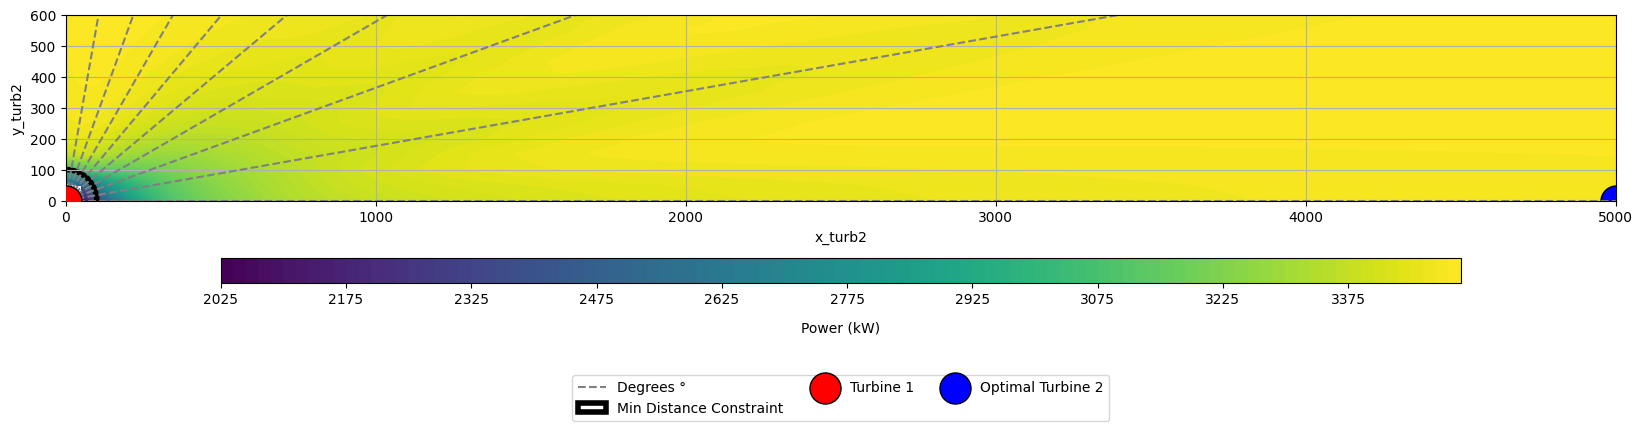

In [58]:
# Visualize the results
from scipy.interpolate import griddata


# Colormap with interpolation
x = expected_power_by_location['x_turb2']
y = expected_power_by_location['y_turb2']
z = expected_power_by_location['prob_weighted_power']
xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((x, y), z, (xi, yi), method='linear')

plt.figure(figsize=(20, 6))
plt.contourf(xi, yi, zi, levels=100, cmap='viridis')
cbar = plt.colorbar(label='Expected Power Generated', orientation='horizontal', pad=-0.2, aspect=50, shrink=0.8)
cbar.ax.set_xlabel('Power (kW)', labelpad=10)

# Add angles
for i, angle in enumerate([0, 10, 20, 30, 40, 50, 60, 70, 80, 90]):
    radians = np.deg2rad(angle)
    label = f'Degrees °' if i == 0 else None  # Add label only to the first line
    plt.plot([0, 5000 * np.cos(radians)], [0, 5000 * np.sin(radians)], linestyle='--', color='gray', label=label)


# Plot minimum distance constraint
circle = plt.Circle((0, 0), 100, color='black', fill=False, linestyle='-', label='Min Distance Constraint', linewidth=4)
plt.gca().add_artist(circle)

# Turbine Positions
plt.scatter(0, 0, color='red', label='Turbine 1', s=500, edgecolor='black', zorder=10)
optimal_x = pyo.value(model.x['x_turb2',0])
optimal_y = pyo.value(model.x['y_turb2',0])
plt.scatter(optimal_x, optimal_y, color='blue', label='Optimal Turbine 2', s=500, edgecolor='black')

# Cosmetics
plt.axis('scaled')
plt.xlim(x.min(), x.max())
plt.ylim(y.min(), y.max())
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.9), ncol=3)
plt.xlabel('x_turb2')
plt.ylabel('y_turb2')
#plt.title('Colormap of Turbine 2 Power across x_turb2 and y_turb2 (Interpolated)')
plt.grid(True)
plt.show()


In [59]:


expected_power = expected_power_for_location(x_turb2_value = 0, y_turb2_value = 500 , wind_df=wind_df, cl_tool=cl_tool)
print(f"Expected Power (weighted by probability): {expected_power:.2f}")

expected_power = expected_power_for_location(x_turb2_value = pyo.value(model.x['x_turb2', 0]), y_turb2_value = pyo.value(model.x['y_turb2',0]) , wind_df=wind_df, cl_tool=cl_tool)
print(f"Optimal x_turb2: {pyo.value(model.x['x_turb2', 0]):.2f}")
print(f"Optimal y_turb2: {pyo.value(model.x['y_turb2', 0]):.2f}")
print(f"Expected Power (weighted by probability): {expected_power:.2f}")



Expected Power (weighted by probability): 3388.97
Optimal x_turb2: 5000.00
Optimal y_turb2: 0.00
Expected Power (weighted by probability): 3505.18


In [62]:
# Generate expected power for each (x_turb2, y_turb2) combination in the specified ranges
x_turb2_range = np.arange(0, 5001, 50)
y_turb2_range = np.arange(0, 601, 10)

results = []
for x_val in x_turb2_range:
    for y_val in y_turb2_range:
        exp_power = expected_power_for_location(x_val, y_val, wind_df, cl_tool)
        results.append({'x_turb2': x_val, 'y_turb2': y_val, 'expected_power': exp_power})

expected_power_grid = pd.DataFrame(results)
expected_power_grid.head()

,x_turb2,y_turb2,expected_power
0,0,0,3283.828544
1,0,10,3285.823704
2,0,20,3287.819007
3,0,30,3289.814235
4,0,40,3291.809631


In [63]:
expected_power_grid

,x_turb2,y_turb2,expected_power
0,0,0,3283.828544
1,0,10,3285.823704
2,0,20,3287.819007
3,0,30,3289.814235
4,0,40,3291.809631
...,...,...,...
6156,5000,560,3503.302664
6157,5000,570,3503.269097
6158,5000,580,3503.235520
6159,5000,590,3503.201943


In [64]:
max_row = expected_power_grid.loc[expected_power_grid['expected_power'].idxmax()]
max_row

x_turb2           5000.000000
y_turb2              0.000000
expected_power    3505.184742
Name: 6100, dtype: float64

In [65]:
expected_power_grid

,x_turb2,y_turb2,expected_power
0,0,0,3283.828544
1,0,10,3285.823704
2,0,20,3287.819007
3,0,30,3289.814235
4,0,40,3291.809631
...,...,...,...
6156,5000,560,3503.302664
6157,5000,570,3503.269097
6158,5000,580,3503.235520
6159,5000,590,3503.201943


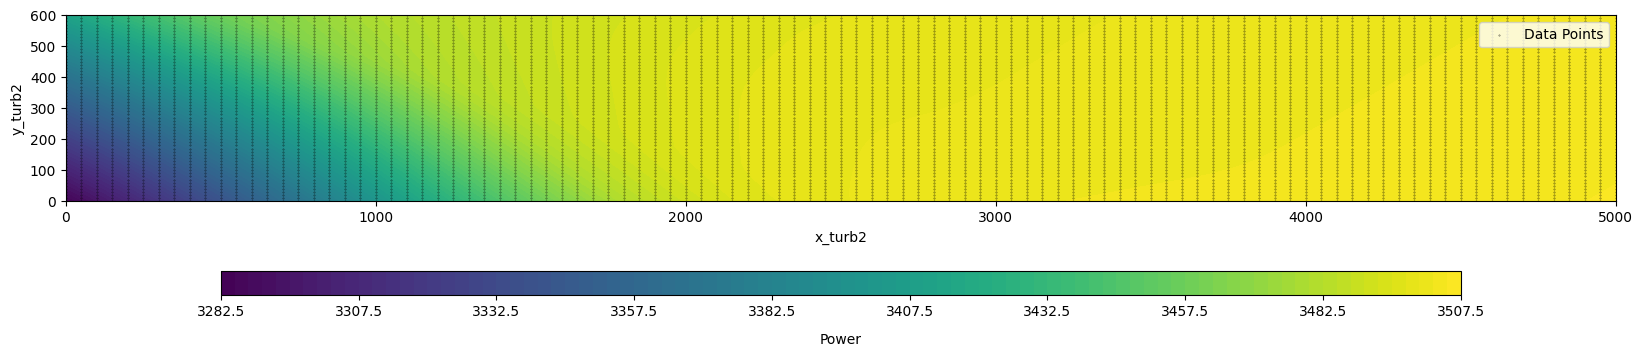

In [66]:
from src.visualize import plot_two_turbine_results
plot_two_turbine_results(expected_power_grid, zfeature="expected_power", dpoint_size=0.1)
